## Task 3. A/B test: Linearized metrics

### 1. Importing libraries

In [5]:
import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statistics
import numpy as np

### 2. Retrieving data from database

In [6]:
connection = {'host': 'https://clickhouse.lab.karpov.courses/',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [47]:
 q = '''
select distinct user_id, exp_group, sum(action='like') as likes, sum(action='view') as views, likes/views as ctr
from {db}.feed_actions 
where (toDate(time) between '2023-01-31' and '2023-02-06') and exp_group in (1,2)
group by exp_group, user_id
'''

In [48]:
 df = ph.read_clickhouse(q, connection=connection)
df

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750
...,...,...,...,...,...
20026,132567,1,45,296,0.152027
20027,30872,1,11,59,0.186441
20028,25383,2,42,127,0.330709
20029,139020,2,24,114,0.210526


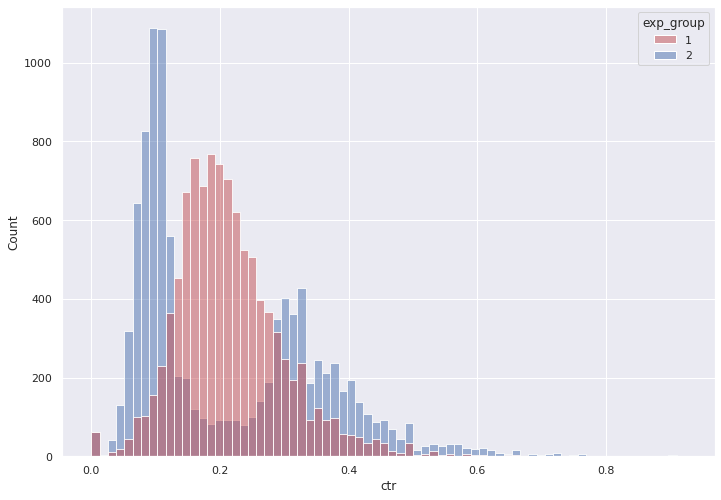

In [49]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [71]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

# По результатам t-теста значения CTR в двух группах не отличаются.

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [72]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

# По результатам теста Манна-Уитни значения CTR в двух группах отличаются.

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [52]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()



<AxesSubplot:xlabel='ctr', ylabel='Count'>

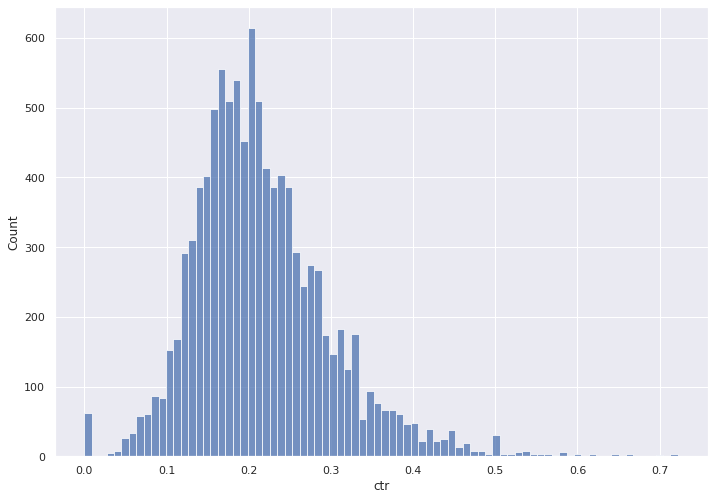

In [53]:
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

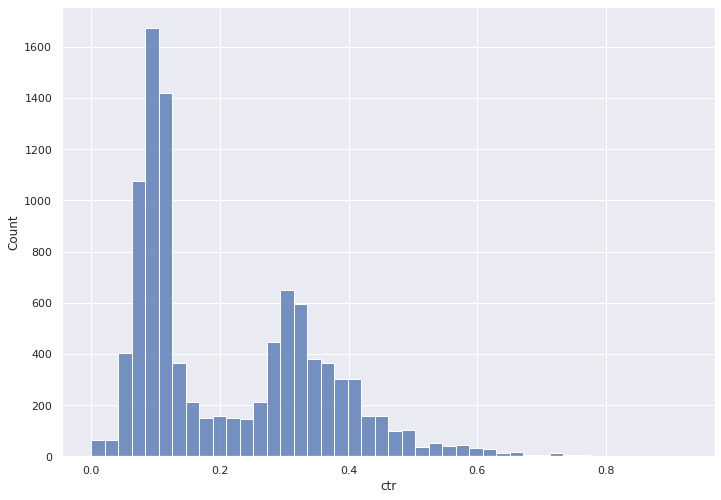

In [54]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, 
             kde = False)

In [55]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)


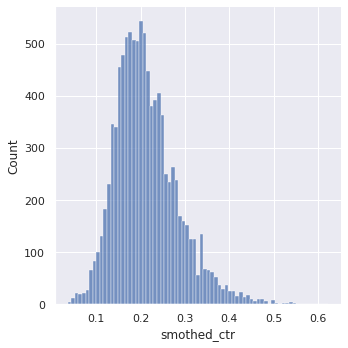

In [57]:
sns.displot(group1.smothed_ctr, 
             kde = False)

In [58]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)


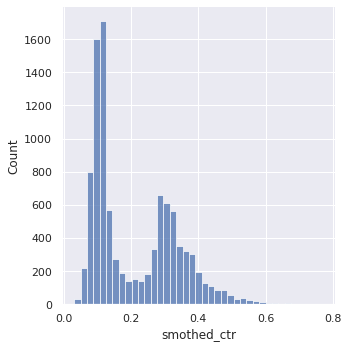

In [60]:
sns.displot(group2.smothed_ctr, 
             kde = False)

In [61]:
stats.ttest_ind(group1['smothed_ctr'], group2['smothed_ctr'], equal_var=False) 

#Т-тест на сглаженном CTR говорит нам, что разница в экспериментальных группах есть.  

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [62]:
likes1 = df.loc[df['exp_group'] == 1, 'likes'].to_numpy()
views1 = df.loc[df['exp_group'] == 1, 'views'].to_numpy()
likes2 = df.loc[df['exp_group'] == 2, 'likes'].to_numpy()
views2 = df.loc[df['exp_group'] == 2, 'views'].to_numpy()

In [63]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

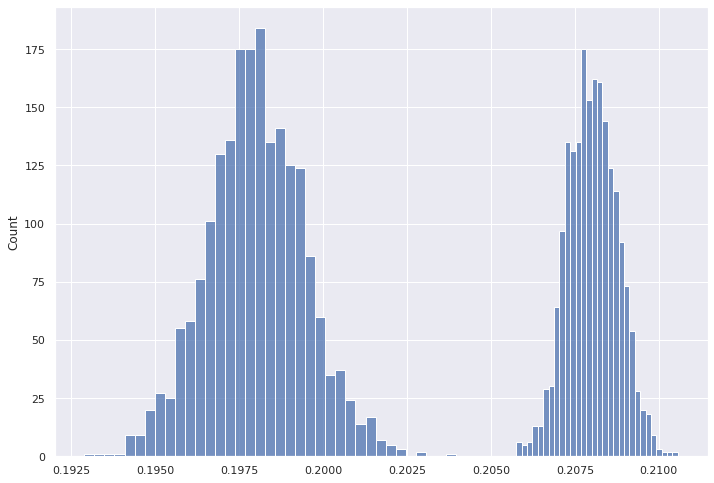

In [64]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

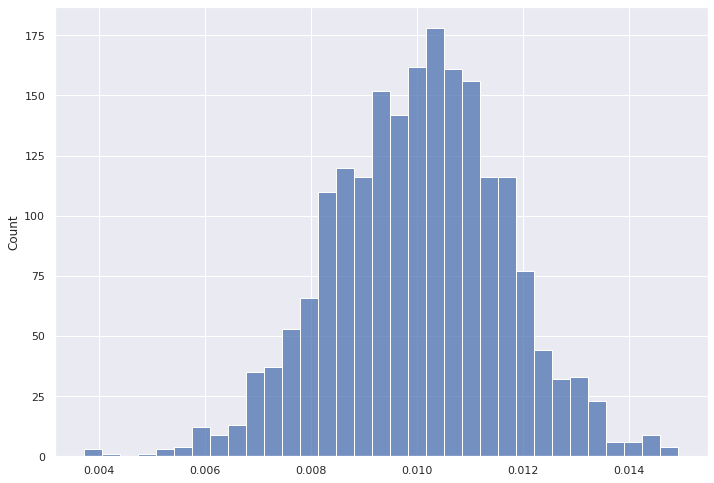

In [73]:
sns.histplot(ctr1 - ctr2)
# Пуассоновский бутстреп показывает, что данные глобального CTR не пересекаются и что CTR 1-ой группы больше CTR 2-ой группы.

In [67]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

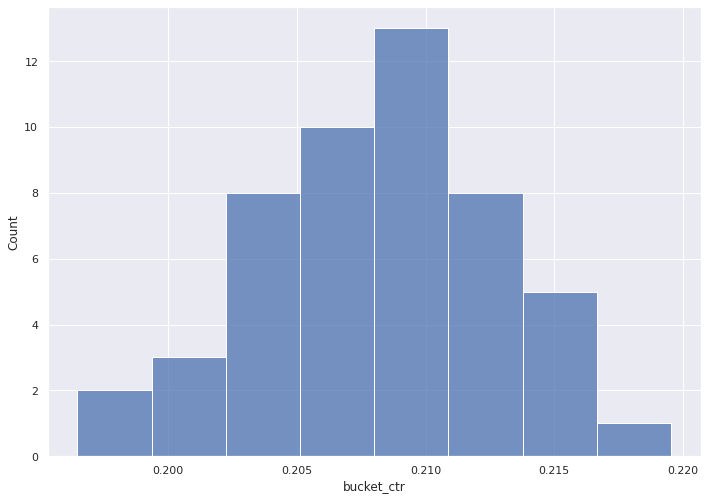

In [68]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr)


<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

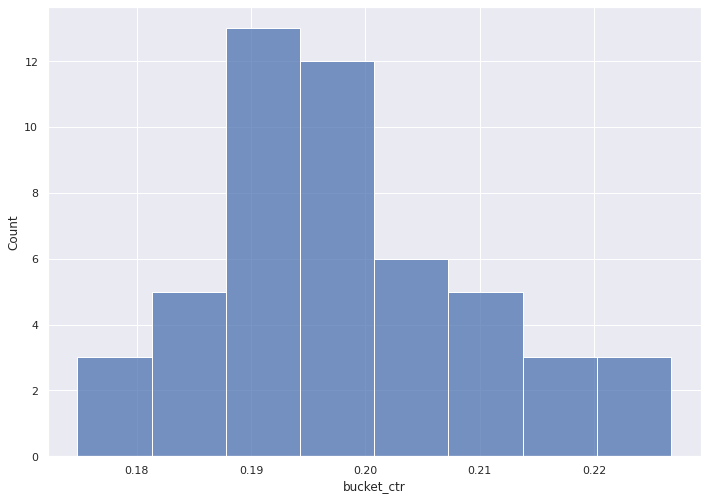

In [69]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr)


In [77]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

# Зона перекрещивающихся значений между бакетами двух групп достаточно мала

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [78]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

# И снова мы видим, что значения CTR в двух группах отличаются

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

### 3. Groups 1 and 2

In [7]:
query = '''
select distinct user_id, exp_group, sum(action='like') as likes, sum(action='view') as views, likes/views as ctr
from {db}.feed_actions 
where (toDate(time) between '2023-01-31' and '2023-02-06')
group by exp_group, user_id
'''

In [8]:
df = ph.read_clickhouse(query, connection=connection)
df

,user_id,exp_group,likes,views,ctr
0,115383,3,9,30,0.300000
1,18392,1,7,32,0.218750
2,123580,3,13,48,0.270833
3,131473,2,14,134,0.104478
4,107323,4,5,31,0.161290
...,...,...,...,...,...
50144,27030,0,8,39,0.205128
50145,122758,3,30,198,0.151515
50146,132567,1,45,296,0.152027
50147,122190,3,19,65,0.292308


In [9]:
df_groups12 = df[df['exp_group'].isin([1, 2])].copy()

In [10]:
ctr_control12 = df_groups12.loc[df_groups12['exp_group'] == 1, 'likes'].sum() / df_groups12.loc[df_groups12['exp_group'] == 1, 'views'].sum()
df_groups12['linearized_likes'] = df_groups12['likes'] - ctr_control12 * df_groups12['views']

In [11]:
stats.ttest_ind(df_groups12.loc[df_groups12['exp_group'] == 1, 'linearized_likes'], df_groups12.loc[df_groups12['exp_group'] == 2, 'linearized_likes'], equal_var=False) 

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

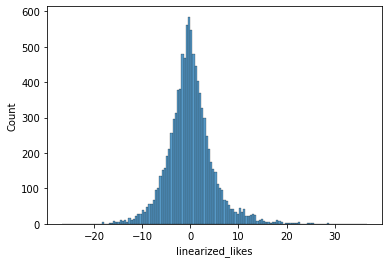

In [12]:
sns.histplot(df_groups12.loc[df_groups12['exp_group'] == 1, 'linearized_likes']) 

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

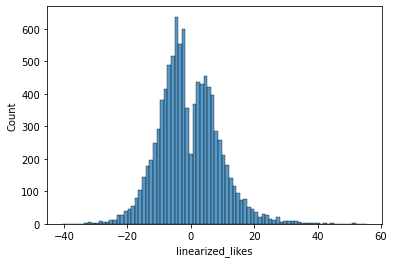

In [13]:
sns.histplot(df_groups12.loc[df_groups12['exp_group'] == 2, 'linearized_likes'])

### 4. Groups 0 and 3

In [14]:
df_groups03 = df[df['exp_group'].isin([0, 3])].copy()

In [15]:
ctr_control03 = df_groups03.loc[df_groups03['exp_group'] == 0, 'likes'].sum() / df_groups03.loc[df_groups03['exp_group'] == 0, 'views'].sum()
df_groups03['linearized_likes'] = df_groups03['likes'] - ctr_control03 * df_groups03['views']



In [16]:
stats.ttest_ind(df_groups03.loc[df_groups03['exp_group'] == 0, 'linearized_likes'], df_groups03.loc[df_groups03['exp_group'] == 3, 'linearized_likes'], equal_var=False) 

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

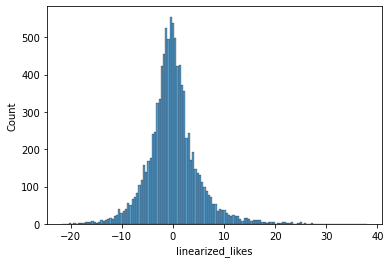

In [17]:
sns.histplot(df_groups03.loc[df_groups03['exp_group'] == 0, 'linearized_likes']) 

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

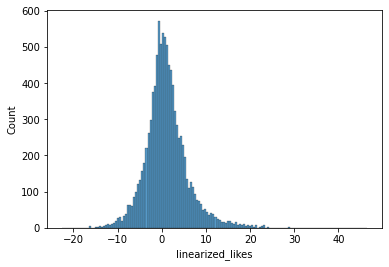

In [18]:
sns.histplot(df_groups03.loc[df_groups03['exp_group'] == 3, 'linearized_likes'])

### 4. Results

* For Groups 0 and 3, the test results for the metric of linearized likes remained the same compared to the test for smoothed CTR. There are significant differences, with the CTR in the experimental group being higher than in the control group. The p-value did not decrease.
* For Groups 1 and 2, the test results for the metric of linearized likes remained the same compared to the test for smoothed CTR. There are significant differences, with the CTR in the experimental group being lower than in the control group. The p-value decreased.